# 1006개의 데이터로 Transfer_Learning 하기

- VGG19 모델에 1006개의 데이터를 넣고 학습을 시켜보자
- Augmentation을 하였을 때와 하지 않았을 때의 성능의 차이를 살펴보자

## Step 1. 실험환경 set-up

#### 라이브러리 실행

In [1]:
from tensorflow.keras.models import Sequential, load_model

import os           
import numpy             as np  
import tensorflow        as tf
import matplotlib.pyplot as plt

#### GPU 사용 여부보기

In [2]:
gpus = tf.config.experimental.list_logical_devices("GPU")

if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print(f"Running on multiple GPUs {[gpu.name for gpu in gpus]}")

elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy()
    print(f"Running on single GPU {gpus[0].name}")

else:
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

print(f"Number of accelerators: {strategy.num_replicas_in_sync}")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Running on multiple GPUs ['/device:GPU:0', '/device:GPU:1']
Number of accelerators: 2


#### 필요한 변수들 생성

In [3]:
IMAGE_SIZE = [1024, 1360]                  # 이미지 사이즈 변수
BATCH_SIZE = 32                            # BATCH_SIZE 변수
EPOCHS     = 150                           # EPOCH 크기 변수
AUTOTUNE   = tf.data.experimental.AUTOTUNE # 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수

## Step 2. 데이터 준비하기

먼저 아래의 링크에서 데이터를 다운 받을 것

https://drive.google.com/drive/folders/1Pi5qyX080zY2IdGT1TvvLraBO9DHBxJl?usp=sharing

받은 후 터미널 창에 아래의 명령어들을 차례로 입력

```
$ cd ~/Downloads && cp CellPin ~/aiffel
```

#### 데이터의 개수 확인

In [5]:
# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv("HOME"), "aiffel/CellPin")
print(ROOT_PATH)

# 각 데이터 불러오기
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + "/train/*/*"))
test_filenames  = tf.io.gfile.glob(str(ROOT_PATH + "/test/*/*"))
val_filenames   = tf.io.gfile.glob(str(ROOT_PATH + "/val/*/*"))

# 데이터 갯수 확인하기
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

/home/mochafreddo/cellpin/CellPin_0601/CellPin
780
260
260


#### train 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if 'normal' in filename])
print('NORMAL images count in Train set :' + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in train_filenames if 'cpe' in filename])
print('CPE images count in Train set :' + str(COUNT_CPE))

NORMAL images count in Train set :429
CPE images count in Train set :351


#### val 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [7]:
COUNT_NORMAL = len([filename for filename in val_filenames if 'normal' in filename])
print('NORMAL images count in Validation set :' + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in val_filenames if 'cpe' in filename])
print('CPE images count in Validation set :' + str(COUNT_CPE))

NORMAL images count in Validation set :143
CPE images count in Validation set :117


#### test 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [8]:
COUNT_NORMAL = len([filename for filename in test_filenames if 'normal' in filename])
print('NORMAL images count in Test set :' + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in test_filenames if 'cpe' in filename])
print('CPE images count in Test set :' + str(COUNT_CPE))

NORMAL images count in Test set :143
CPE images count in Test set :117


#### tf.data 인스턴스를 만들기

In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds   = tf.data.Dataset.from_tensor_slices(val_filenames)

#### train data와 val data의 개수 확인

In [12]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print('Train images count :' + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print('Validation images count :' + str(VAL_IMG_COUNT))

Train images count :780
Validation images count :260


#### 라벨 이름들 확인

In [13]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/train/*"))])
print(CLASS_NAMES)

['normal' 'cpe']


#### 라벨링 함수를 만들어 보기

In [14]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "cpe"

#### decode_img 함수와 process_path 함수를 만들기

In [17]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels = 3)
    
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
    
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img   = tf.io.read_file(file_path)
    img   = decode_img(img)
    
    return img, label

#### train과 val에 함수들 적용해주기

In [18]:
train_ds = train_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds   = val_list_ds.map(process_path,   num_parallel_calls = AUTOTUNE)

#### 전처리 함수 만들기 및 적용

In [19]:
def augment(image,label):
    image = tf.image.flip_left_right(image)  # 좌우 반전
    image = tf.image.flip_up_down(image)     # 상하 반전
    return image,label

def prepare_for_training(ds, shuffle_buffer_size = 1000, with_aug = False):
    if  with_aug:
        ds = ds.map(
            augment,  # augment 함수 적용
            num_parallel_calls = 2
            )    

    ds = ds.shuffle(buffer_size = shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size = AUTOTUNE)

    return ds

In [20]:
train_ds_no_aug = prepare_for_training(train_ds, with_aug = False)
val_ds_no_aug   = prepare_for_training(val_ds,   with_aug = False)
train_ds_aug    = prepare_for_training(train_ds, with_aug = True)
val_ds_aug      = prepare_for_training(val_ds,   with_aug = True)

#### Image shape를 변경 체크하기

In [21]:
for image, label in train_ds.take(1):
    print("Image shape :", image.numpy().shape)
    print("Label :",       label.numpy().shape)

Image shape : (32, 256, 256, 3)
Label : (32,)


#### test 데이터 셋도 만들어 보기 & 데이터의 갯수 확인

In [23]:
test_list_ds     = tf.data.Dataset.list_files(str(ROOT_PATH + "/test/*/*"))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds          = test_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
test_ds          = test_ds.batch(BATCH_SIZE)
print(TEST_IMAGE_COUNT)

260


## Step 3. 데이터 시각화

#### 16개의 샘플 꺼내서 확인

In [24]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10,10))
    
    for n in range(16):
        ax = plt.subplot(4, 4, n + 1)
        plt.imshow(image_batch[n])
        
        if list(label_batch[n])[0].numpy() == 0:
            plt.title("CPE")
        else:
            plt.title("NORMAL")
        
        plt.axis("off")

        
show_batch(image_batch.numpy(), label_batch)

#### model building(DenseNet, Freeze)

In [27]:
with strategy.scope():
    densenet_layer = tf.keras.applications.DenseNet201(include_top = False,
                                                       weights     = "imagenet",
                                                       input_shape = (256, 256, 3),
                                                       classes     = 1)
    
    fc_layer = [
        tf.keras.layers.GlobalMaxPool2D(),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Activation("sigmoid")
    ]
    
    densenet_layer.trainable = False
    
    no_aug_model   = tf.keras.models.Sequential([densenet_layer] + fc_layer)
    with_aug_model = tf.keras.models.Sequential([densenet_layer] + fc_layer)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [28]:
no_aug_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 8, 8, 1920)        18321984  
_________________________________________________________________
global_max_pooling2d (Global (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1921      
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 18,323,905
Trainable params: 1,921
Non-trainable params: 18,321,984
_________________________________________________________________


In [29]:
with_aug_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 8, 8, 1920)        18321984  
_________________________________________________________________
global_max_pooling2d (Global (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1921      
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 18,323,905
Trainable params: 1,921
Non-trainable params: 18,321,984
_________________________________________________________________


## Step 4. 모델 훈련

#### GPU사용하여 model complie

In [30]:
with strategy.scope():
    METRICS = [
        "accuracy",
        tf.keras.metrics.Precision(name = "precision"),
        tf.keras.metrics.Recall(name    = "recall")
    ]
    
    no_aug_model.compile(
        optimizer = "adam",
        loss      = "binary_crossentropy",
        metrics   = METRICS
    )
     
    no_aug_check_point = tf.keras.callbacks.ModelCheckpoint(ROOT_PATH + "/0602_data1300_model4/DenseNet201_FC_no_aug.h5")

In [31]:
with strategy.scope():
    with_aug_model.compile(
        optimizer = "adam",
        loss      = "binary_crossentropy",
        metrics   = METRICS
    )
    

    with_aug_check_point = tf.keras.callbacks.ModelCheckpoint(ROOT_PATH + "/0602_data1300_model4/DenseNet201_FC_with_aug.h5")

#### 모델 fitting

In [32]:
with strategy.scope():
    history_no_aug_model = no_aug_model.fit(
        train_ds_no_aug,
        steps_per_epoch  = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs           = EPOCHS,
        validation_data  = val_ds_no_aug,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        callbacks        = [no_aug_check_point]
    )

Epoch 1/150
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = nccl, num_packs = 1
24/24 [==============================] - 65s 1s/step - loss: 0.7375 - accuracy: 0.5577 - precision: 0.5294 - recall: 0.5185 - val_loss: 0.3736 - val_accuracy: 0.8750 - val_precision: 0.9038 - val_recall: 0.8103
Epoch 2/150
24/24 [==============================] - 23s 983ms/step - loss: 0.3271 - accuracy: 0.8970 - precision: 0.9164 - recall: 0.8529 - val_loss: 0.2746 - val_accuracy: 0.9102 - val_precision: 0.9115 - val_recall: 0.8879
Epoch 3/150
24/24 [==============================] - 23s 1s/step - loss: 0.2447 - accuracy: 0.9286 - precision: 0.9612 - recall: 0.8780 - val_loss: 0.2218 - val_accuracy: 0.9180 - val_precision: 0.9358 - val_recall: 0.8793
Epoch 4/150
24/24 [==============================] - 25s 1s/step - loss: 0.2170 - accuracy: 0.9184 - precision: 0.9256 - recall: 0.8947 - val_loss: 0.1980 - v

24/24 [==============================] - 21s 908ms/step - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0914 - val_accuracy: 0.9570 - val_precision: 0.9561 - val_recall: 0.9478
Epoch 73/150
24/24 [==============================] - 21s 889ms/step - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0920 - val_accuracy: 0.9609 - val_precision: 0.9417 - val_recall: 0.9741
Epoch 74/150
24/24 [==============================] - 21s 906ms/step - loss: 0.0180 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0907 - val_accuracy: 0.9570 - val_precision: 0.9561 - val_recall: 0.9478
Epoch 75/150
24/24 [==============================] - 21s 910ms/step - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0910 - val_accuracy: 0.9570 - val_precision: 0.9561 - val_recall: 0.9478
Epoch 76/150
24/24 [==============================] - 21s 907ms/step - loss: 0.0171 - accuracy: 1.0000 - 

Epoch 144/150
24/24 [==============================] - 21s 911ms/step - loss: 0.0049 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0988 - val_accuracy: 0.9570 - val_precision: 0.9561 - val_recall: 0.9478
Epoch 145/150
24/24 [==============================] - 21s 924ms/step - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0987 - val_accuracy: 0.9570 - val_precision: 0.9558 - val_recall: 0.9474
Epoch 146/150
24/24 [==============================] - 21s 914ms/step - loss: 0.0043 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0994 - val_accuracy: 0.9570 - val_precision: 0.9407 - val_recall: 0.9652
Epoch 147/150
24/24 [==============================] - 21s 914ms/step - loss: 0.0052 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0995 - val_accuracy: 0.9570 - val_precision: 0.9407 - val_recall: 0.9652
Epoch 148/150
24/24 [==============================] - 21s 916ms/step - loss: 0.0051 - a

In [33]:
with strategy.scope():
    history_with_aug_model = with_aug_model.fit(
        train_ds_aug,
        steps_per_epoch  = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs           = EPOCHS,
        validation_data  = val_ds_aug,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        callbacks        = [with_aug_check_point]
    )

Epoch 1/150
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = nccl, num_packs = 1
24/24 [==============================] - 62s 1s/step - loss: 0.1015 - accuracy: 0.9671 - precision: 0.9521 - recall: 0.9611 - val_loss: 0.0879 - val_accuracy: 0.9648 - val_precision: 0.9907 - val_recall: 0.9298
Epoch 2/150
24/24 [==============================] - 23s 994ms/step - loss: 0.1062 - accuracy: 0.9574 - precision: 0.9493 - recall: 0.9554 - val_loss: 0.0839 - val_accuracy: 0.9648 - val_precision: 0.9818 - val_recall: 0.9391
Epoch 3/150
24/24 [==============================] - 23s 1s/step - loss: 0.0828 - accuracy: 0.9793 - precision: 0.9829 - recall: 0.9693 - val_loss: 0.0957 - val_accuracy: 0.9570 - val_precision: 0.9815 - val_recall: 0.9217
Epoch 4/150
24/24 [==============================] - 23s 1s/step - loss: 0.1006 - accuracy: 0.9704 - precision: 0.9760 - recall: 0.9567 - val_loss: 0.0901 - v

24/24 [==============================] - 21s 897ms/step - loss: 0.0105 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0986 - val_accuracy: 0.9609 - val_precision: 0.9732 - val_recall: 0.9397
Epoch 73/150
24/24 [==============================] - 22s 940ms/step - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1014 - val_accuracy: 0.9609 - val_precision: 0.9730 - val_recall: 0.9391
Epoch 74/150
24/24 [==============================] - 21s 914ms/step - loss: 0.0126 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1009 - val_accuracy: 0.9609 - val_precision: 0.9730 - val_recall: 0.9391
Epoch 75/150
24/24 [==============================] - 22s 941ms/step - loss: 0.0112 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1020 - val_accuracy: 0.9609 - val_precision: 0.9730 - val_recall: 0.9391
Epoch 76/150
24/24 [==============================] - 21s 911ms/step - loss: 0.0099 - accuracy: 1.0000 - 

Epoch 144/150
24/24 [==============================] - 21s 930ms/step - loss: 0.0033 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1096 - val_accuracy: 0.9609 - val_precision: 0.9725 - val_recall: 0.9381
Epoch 145/150
24/24 [==============================] - 21s 912ms/step - loss: 0.0044 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1099 - val_accuracy: 0.9609 - val_precision: 0.9732 - val_recall: 0.9397
Epoch 146/150
24/24 [==============================] - 21s 889ms/step - loss: 0.0035 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1014 - val_accuracy: 0.9609 - val_precision: 0.9730 - val_recall: 0.9391
Epoch 147/150
24/24 [==============================] - 21s 924ms/step - loss: 0.0042 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1040 - val_accuracy: 0.9609 - val_precision: 0.9732 - val_recall: 0.9397
Epoch 148/150
24/24 [==============================] - 21s 932ms/step - loss: 0.0030 - a

## Step 5. 결과 확인 및 시각화

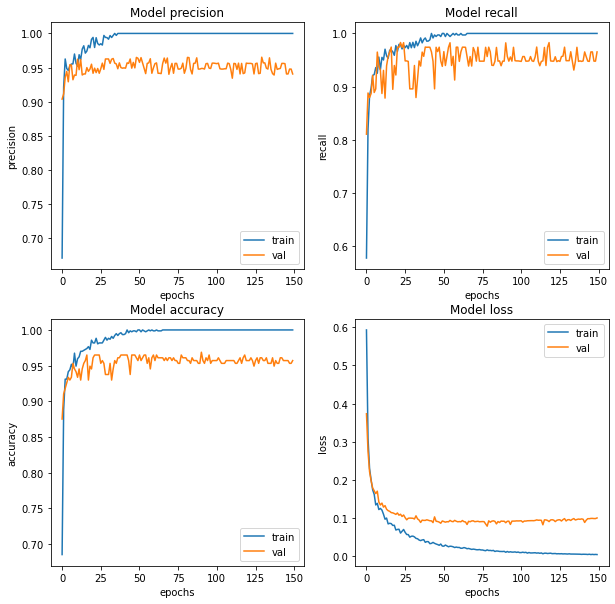

In [34]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax      = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title(f"Model {met}")
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

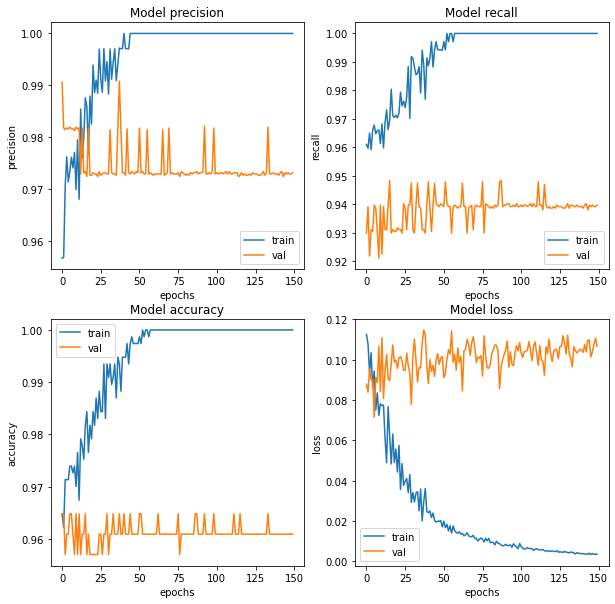

In [35]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax      = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title(f"Model {met}")
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

## Step 6. Test dataset 검정해보기

In [36]:
with strategy.scope():
    no_aug_model = tf.keras.models.load_model(ROOT_PATH + "/0602_data1300_model4/DenseNet201_FC_no_aug.h5")

    loss, acc, prec, rec = no_aug_model.evaluate(test_ds)

9/9 [==============================] - 12s 273ms/step - loss: 0.0704 - accuracy: 0.9769 - precision: 0.9826 - recall: 0.9658


In [37]:
with strategy.scope():
    with_aug_model = tf.keras.models.load_model(ROOT_PATH + "/0602_data1300_model4/DenseNet201_FC_with_aug.h5")

    loss, acc, prec, rec = with_aug_model.evaluate(test_ds)

9/9 [==============================] - 11s 208ms/step - loss: 0.1042 - accuracy: 0.9692 - precision: 0.9910 - recall: 0.9402


## Step 7. Freeze 풀고 다시 학습하기

#### augmentation 안한 모델 Freeze 풀어주기

In [38]:
with strategy.scope():
    no_aug_model.layers[0].trainable = True
    no_aug_model.layers[0].trainable

In [39]:
no_aug_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 8, 8, 1920)        18321984  
_________________________________________________________________
global_max_pooling2d (Global (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1921      
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 18,323,905
Trainable params: 18,094,849
Non-trainable params: 229,056
_________________________________________________________________


#### augmentation 한 모델 Freeze 풀어주기

In [40]:
with strategy.scope():
    with_aug_model.layers[0].trainable = True
    with_aug_model.layers[0].trainable

In [41]:
with_aug_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 8, 8, 1920)        18321984  
_________________________________________________________________
global_max_pooling2d (Global (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1921      
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 18,323,905
Trainable params: 18,094,849
Non-trainable params: 229,056
_________________________________________________________________


#### GPU를 사용하여 모델을 장착

In [42]:
with strategy.scope():
    no_aug_model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
        loss      = "binary_crossentropy",
        metrics   = METRICS
    )
     
    no_aug_check_point = tf.keras.callbacks.ModelCheckpoint(ROOT_PATH + "/0602_data1300_model4/DenseNet201_no_aug.h5")

In [43]:
with strategy.scope():
    with_aug_model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
        loss      = "binary_crossentropy",
        metrics   = METRICS
    )
    
    with_aug_check_point = tf.keras.callbacks.ModelCheckpoint(ROOT_PATH + "/0602_data1300_model4/DenseNet201_with_aug.h5")

#### 모델 학습

In [44]:
with strategy.scope():
    history_no_aug_model = no_aug_model.fit(
        train_ds_no_aug,
        steps_per_epoch  = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs           = EPOCHS,
        validation_data  = val_ds_no_aug,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        callbacks        = [no_aug_check_point]
    )

Epoch 1/150
INFO:tensorflow:batch_all_reduce: 604 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 604 all-reduces with algorithm = nccl, num_packs = 1
24/24 [==============================] - 142s 1s/step - loss: 11.1042 - accuracy: 0.5152 - precision: 0.6201 - recall: 0.9710 - val_loss: 0.2648 - val_accuracy: 0.9102 - val_precision: 0.9792 - val_recall: 0.8174
Epoch 2/150
24/24 [==============================] - 22s 958ms/step - loss: 1.9132 - accuracy: 0.8372 - precision: 0.7498 - recall: 0.9634 - val_loss: 0.6302 - val_accuracy: 0.8516 - val_precision: 0.9634 - val_recall: 0.6930
Epoch 3/150
24/24 [==============================] - 23s 967ms/step - loss: 0.3894 - accuracy: 0.9435 - precision: 0.9345 - recall: 0.9397 - val_loss: 0.8738 - val_accuracy: 0.8555 - val_precision: 0.9762 - val_recall: 0.7009
Epoch 4/150
24/24 [==============================] - 23s 969ms/step - loss: 0.6724 - accuracy: 0.9396 - precision: 0.9373 - recall: 0.9398 - val_loss

24/24 [==============================] - 22s 957ms/step - loss: 0.0011 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3441 - val_accuracy: 0.9531 - val_precision: 0.9643 - val_recall: 0.9310
Epoch 73/150
24/24 [==============================] - 22s 947ms/step - loss: 6.1424e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3368 - val_accuracy: 0.9453 - val_precision: 0.9554 - val_recall: 0.9224
Epoch 74/150
24/24 [==============================] - 22s 930ms/step - loss: 0.0056 - accuracy: 0.9968 - precision: 0.9964 - recall: 0.9960 - val_loss: 0.3369 - val_accuracy: 0.9492 - val_precision: 0.9550 - val_recall: 0.9298
Epoch 75/150
24/24 [==============================] - 22s 965ms/step - loss: 4.7940e-04 - accuracy: 0.9998 - precision: 1.0000 - recall: 0.9995 - val_loss: 0.3423 - val_accuracy: 0.9531 - val_precision: 0.9565 - val_recall: 0.9402
Epoch 76/150
24/24 [==============================] - 23s 972ms/step - loss: 3.3287e-04 - accurac

Epoch 108/150
24/24 [==============================] - 23s 975ms/step - loss: 3.1686e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3337 - val_accuracy: 0.9492 - val_precision: 0.9474 - val_recall: 0.9391
Epoch 109/150
24/24 [==============================] - 23s 985ms/step - loss: 1.4573e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3549 - val_accuracy: 0.9492 - val_precision: 0.9474 - val_recall: 0.9391
Epoch 110/150
24/24 [==============================] - 23s 980ms/step - loss: 0.0079 - accuracy: 0.9989 - precision: 1.0000 - recall: 0.9975 - val_loss: 0.3236 - val_accuracy: 0.9492 - val_precision: 0.9391 - val_recall: 0.9474
Epoch 111/150
24/24 [==============================] - 23s 992ms/step - loss: 6.2466e-04 - accuracy: 0.9998 - precision: 0.9997 - recall: 1.0000 - val_loss: 0.3182 - val_accuracy: 0.9492 - val_precision: 0.9402 - val_recall: 0.9483
Epoch 112/150
24/24 [==============================] - 23s 979ms/step - loss

Epoch 144/150
24/24 [==============================] - 23s 989ms/step - loss: 0.0085 - accuracy: 0.9970 - precision: 0.9943 - recall: 0.9988 - val_loss: 0.2519 - val_accuracy: 0.9570 - val_precision: 0.9646 - val_recall: 0.9397
Epoch 145/150
24/24 [==============================] - 23s 1000ms/step - loss: 0.0143 - accuracy: 0.9976 - precision: 0.9952 - recall: 0.9995 - val_loss: 0.2954 - val_accuracy: 0.9609 - val_precision: 0.9643 - val_recall: 0.9474
Epoch 146/150
24/24 [==============================] - 23s 976ms/step - loss: 9.2661e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2388 - val_accuracy: 0.9688 - val_precision: 0.9739 - val_recall: 0.9573
Epoch 147/150
24/24 [==============================] - 22s 953ms/step - loss: 0.0021 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2201 - val_accuracy: 0.9688 - val_precision: 0.9735 - val_recall: 0.9565
Epoch 148/150
24/24 [==============================] - 23s 987ms/step - loss: 0.005

In [45]:
with strategy.scope():
    history_with_aug_model = with_aug_model.fit(
        train_ds_aug,
        steps_per_epoch  = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs           = EPOCHS,
        validation_data  = val_ds_aug,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        callbacks        = [with_aug_check_point]
    )

Epoch 1/150
INFO:tensorflow:batch_all_reduce: 604 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 604 all-reduces with algorithm = nccl, num_packs = 1
24/24 [==============================] - 148s 1s/step - loss: 4.5643 - accuracy: 0.6546 - precision: 0.7256 - recall: 0.9107 - val_loss: 0.2419 - val_accuracy: 0.9297 - val_precision: 0.9623 - val_recall: 0.8793
Epoch 2/150
24/24 [==============================] - 22s 935ms/step - loss: 1.0164 - accuracy: 0.8730 - precision: 0.8098 - recall: 0.9217 - val_loss: 0.7069 - val_accuracy: 0.8711 - val_precision: 0.9767 - val_recall: 0.7304
Epoch 3/150
24/24 [==============================] - 22s 935ms/step - loss: 0.6748 - accuracy: 0.9299 - precision: 0.8946 - recall: 0.9530 - val_loss: 0.8995 - val_accuracy: 0.8750 - val_precision: 0.9882 - val_recall: 0.7304
Epoch 4/150
24/24 [==============================] - 22s 939ms/step - loss: 0.2056 - accuracy: 0.9641 - precision: 0.9706 - recall: 0.9503 - val_loss:

24/24 [==============================] - 23s 987ms/step - loss: 0.0034 - accuracy: 0.9989 - precision: 0.9976 - recall: 1.0000 - val_loss: 0.2895 - val_accuracy: 0.9531 - val_precision: 0.9554 - val_recall: 0.9386
Epoch 73/150
24/24 [==============================] - 22s 940ms/step - loss: 0.0315 - accuracy: 0.9906 - precision: 0.9823 - recall: 0.9969 - val_loss: 0.2860 - val_accuracy: 0.9648 - val_precision: 0.9817 - val_recall: 0.9386
Epoch 74/150
24/24 [==============================] - 23s 974ms/step - loss: 0.0029 - accuracy: 0.9985 - precision: 0.9967 - recall: 1.0000 - val_loss: 0.3509 - val_accuracy: 0.9648 - val_precision: 0.9817 - val_recall: 0.9386
Epoch 75/150
24/24 [==============================] - 22s 964ms/step - loss: 7.5861e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4094 - val_accuracy: 0.9492 - val_precision: 0.9813 - val_recall: 0.9052
Epoch 76/150
24/24 [==============================] - 22s 963ms/step - loss: 0.0030 - accuracy: 0.999

Epoch 108/150
24/24 [==============================] - 23s 989ms/step - loss: 0.0041 - accuracy: 0.9973 - precision: 0.9938 - recall: 1.0000 - val_loss: 0.4150 - val_accuracy: 0.9648 - val_precision: 0.9646 - val_recall: 0.9561
Epoch 109/150
24/24 [==============================] - 22s 956ms/step - loss: 4.6939e-04 - accuracy: 0.9998 - precision: 1.0000 - recall: 0.9995 - val_loss: 0.3748 - val_accuracy: 0.9609 - val_precision: 0.9646 - val_recall: 0.9478
Epoch 110/150
24/24 [==============================] - 23s 984ms/step - loss: 0.0015 - accuracy: 0.9999 - precision: 1.0000 - recall: 0.9998 - val_loss: 0.3871 - val_accuracy: 0.9570 - val_precision: 0.9558 - val_recall: 0.9474
Epoch 111/150
24/24 [==============================] - 23s 973ms/step - loss: 0.0645 - accuracy: 0.9966 - precision: 1.0000 - recall: 0.9926 - val_loss: 0.3090 - val_accuracy: 0.9609 - val_precision: 0.9417 - val_recall: 0.9741
Epoch 112/150
24/24 [==============================] - 23s 982ms/step - loss: 0.0038

Epoch 144/150
24/24 [==============================] - 22s 952ms/step - loss: 0.0446 - accuracy: 0.9965 - precision: 0.9929 - recall: 1.0000 - val_loss: 0.2795 - val_accuracy: 0.9688 - val_precision: 0.9492 - val_recall: 0.9825
Epoch 145/150
24/24 [==============================] - 23s 969ms/step - loss: 0.0028 - accuracy: 0.9992 - precision: 0.9982 - recall: 1.0000 - val_loss: 0.2193 - val_accuracy: 0.9688 - val_precision: 0.9492 - val_recall: 0.9825
Epoch 146/150
24/24 [==============================] - 22s 936ms/step - loss: 0.0048 - accuracy: 0.9988 - precision: 0.9972 - recall: 1.0000 - val_loss: 0.2811 - val_accuracy: 0.9531 - val_precision: 0.9469 - val_recall: 0.9469
Epoch 147/150
24/24 [==============================] - 22s 965ms/step - loss: 2.8308e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2811 - val_accuracy: 0.9570 - val_precision: 0.9561 - val_recall: 0.9478
Epoch 148/150
24/24 [==============================] - 22s 963ms/step - loss: 0.0015

#### 시각화

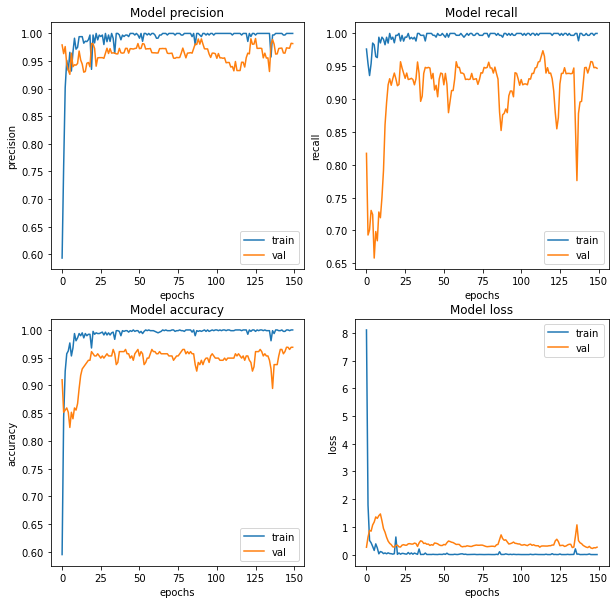

In [46]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax      = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title(f"Model {met}")
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

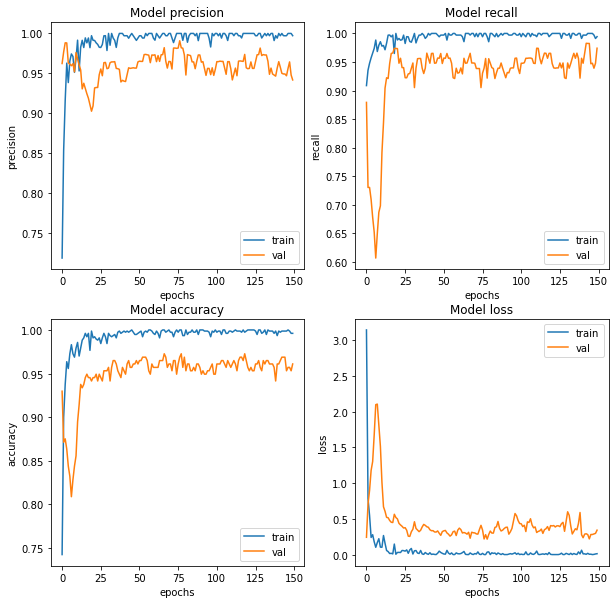

In [47]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax      = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title(f"Model {met}")
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

#### 최종 결과 확인

In [48]:
with strategy.scope():
    no_aug_model = tf.keras.models.load_model(ROOT_PATH + "/0602_data1300_model4/DenseNet201_no_aug.h5")

    loss, acc, prec, rec = no_aug_model.evaluate(test_ds)

9/9 [==============================] - 6s 250ms/step - loss: 0.3252 - accuracy: 0.9615 - precision: 1.0000 - recall: 0.9145


In [49]:
with strategy.scope():
    with_aug_model = tf.keras.models.load_model(ROOT_PATH + "/0602_data1300_model4/DenseNet201_with_aug.h5")

    loss, acc, prec, rec = with_aug_model.evaluate(test_ds)

9/9 [==============================] - 5s 207ms/step - loss: 0.3718 - accuracy: 0.9577 - precision: 0.9649 - recall: 0.9402
